## Running Notes

thresholding-probability map to binary map-if pixels more than threshold-subject otherwise background,may mistake misshaped object,partially transparent object  in image

morphological operations-opening-cleaning tiny isolated pixels

erosion(shrink) and dilation(recovers eroded part)

connector component analysis-small isolated regions that are likely false positive

contour(joins continous points of a boundary) refinement and smoothing-edges not messy,image clear--photo editing medical-gaussian blur(weighted average filter,median part will have more weight and consideration,doesnt remove large isolated objects like morph) and median filtering(replaces each pixel's value with its neighbourhood,while preserving edges and shapes better than gaussian blur for binary mask and better for small scattering all over the image)  to soften boundaries-----used when object is over or under sampled---size,area,perimeter,boundaries--used in openCV

floodfill-to fill the region completely surrounded by object pixels(internal holes like a donut)

activation function- sumweighted sum of inputs with(+) bias,it is a filter of lengths in which the raw data passes,it decides which signals to ampilify and transform,the output,2.pixel level detections(each pixel) and shows wether it belongs,3 stable and faster convergence

relu-positive activation to pass through,return of zeroes to pass through it,advantages-simple and fast to compute,helps gradient flow,faster training,it can suffer from dile relu,leaky-leaks negetive values to pass through to output

sigmoid-converts raw logits to 0 between 1,1/(1+e^-x),x=feature,used in output layer of binary segementation,each pixel as likelihood of being an object,the ouptut will be very interpretable,not ideal for deep hidden layers.

softmax fucntion-multiclass segmentation,raw logits to probabilities,sum of prob will be 1,there will be multiple classes of prob

## Task

Using device: cuda

Processing image 1/1...
IoU before post-processing: 1.0000
Dice before post-processing: 1.0000
IoU after post-processing: 0.9927
Dice after post-processing: 0.9963


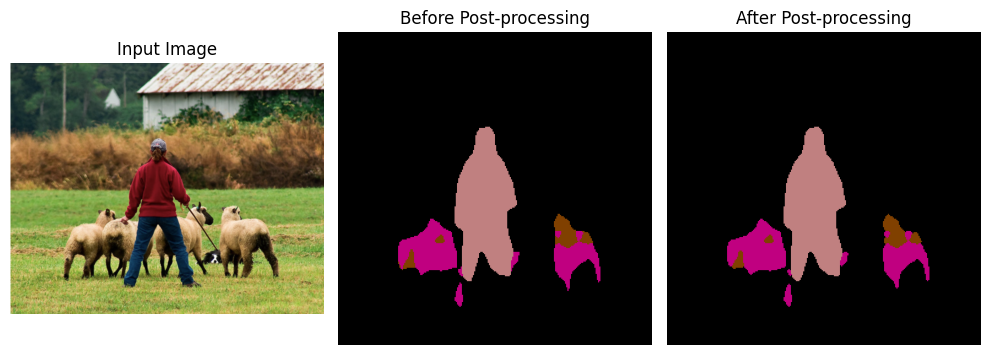

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from scipy.ndimage import binary_opening, binary_closing
import requests
from io import BytesIO

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Pretrained DeepLabV3 (COCO)
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = models.segmentation.deeplabv3_resnet50(weights=weights).to(device).eval()

# ✅ Sample image URLs (PyTorch official demo images)
sample_urls = [
    "https://pytorch.org/assets/images/deeplab1.png"
]

# ✅ Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# ✅ Color palette for segmentation visualization
def decode_segmap(mask):
    label_colors = np.array([
        (0, 0, 0), (128, 0, 0), (0, 128, 0), (128, 128, 0),
        (0, 0, 128), (128, 0, 128), (0, 128, 128), (128, 128, 128),
        (64, 0, 0), (192, 0, 0), (64, 128, 0), (192, 128, 0),
        (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
        (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)
    ])
    r, g, b = np.zeros_like(mask), np.zeros_like(mask), np.zeros_like(mask)
    for l in range(0, len(label_colors)):
        idx = mask == l
        r[idx], g[idx], b[idx] = label_colors[l]
    rgb = np.stack([r, g, b], axis=2)
    return rgb.astype(np.uint8)

# ✅ Metrics for segmentation quality
def compute_iou_and_dice(pred, gt):
    pred, gt = pred.flatten(), gt.flatten()
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    iou = intersection / union if union != 0 else 0
    dice = (2 * intersection) / (pred.sum() + gt.sum()) if (pred.sum() + gt.sum()) != 0 else 0
    return iou, dice

# ✅ Main loop
for idx, url in enumerate(sample_urls):
    print(f"\nProcessing image {idx+1}/{len(sample_urls)}...")

    # Load image
    img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
    tensor = preprocess(img).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(tensor)['out']
    pred_mask = output.argmax(1).squeeze().cpu().numpy()  # multi-class mask

    # Post-processing (morphological cleanup on each class)
    post_processed = np.zeros_like(pred_mask)
    for cls in np.unique(pred_mask):
        cls_mask = (pred_mask == cls)
        post_cls = binary_closing(binary_opening(cls_mask))
        post_processed[post_cls] = cls

    # Compute metrics using binary presence (foreground/background)
    binary_pred = pred_mask > 0
    binary_post = post_processed > 0
    iou_before, dice_before = compute_iou_and_dice(binary_pred, binary_pred)
    iou_after, dice_after = compute_iou_and_dice(binary_post, binary_pred)

    print(f"IoU before post-processing: {iou_before:.4f}")
    print(f"Dice before post-processing: {dice_before:.4f}")
    print(f"IoU after post-processing: {iou_after:.4f}")
    print(f"Dice after post-processing: {dice_after:.4f}")

    # Visualization
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(decode_segmap(pred_mask))
    plt.title("Before Post-processing")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(decode_segmap(post_processed))
    plt.title("After Post-processing")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Using device: cuda
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 170MB/s]



Processing image 1/1...
IoU before post-processing: 1.0000
Dice before post-processing: 1.0000
IoU after post-processing: 0.9927
Dice after post-processing: 0.9963


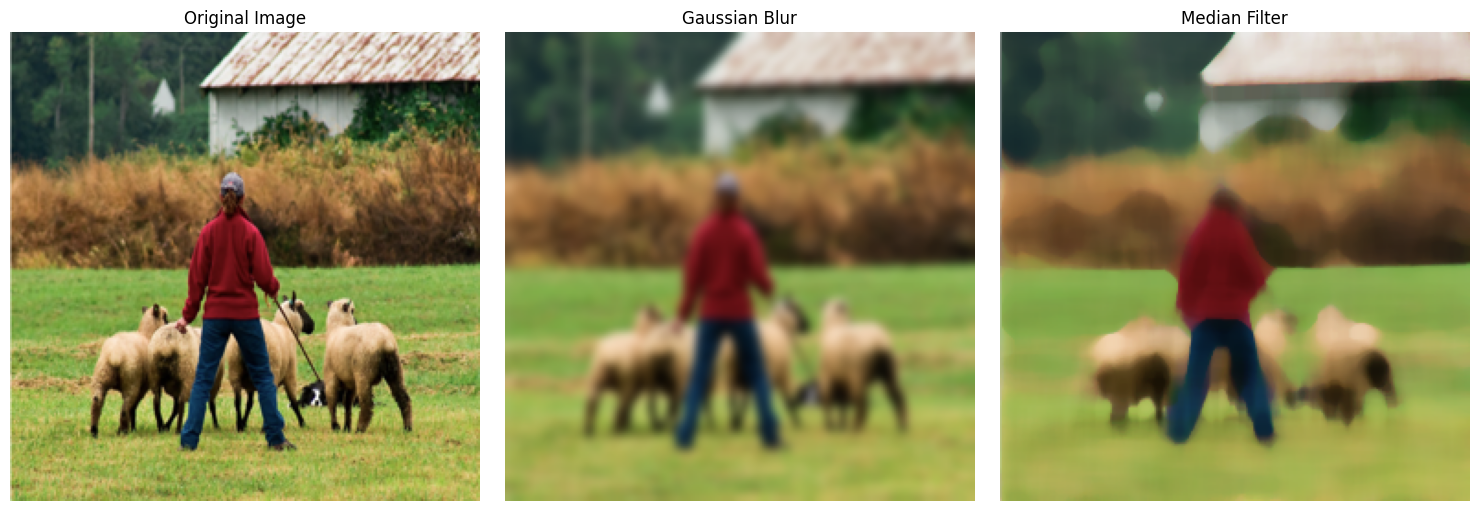

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from scipy.ndimage import binary_opening, binary_closing
import requests
from io import BytesIO
import cv2  # Import OpenCV

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Pretrained DeepLabV3 (COCO)
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = models.segmentation.deeplabv3_resnet50(weights=weights).to(device).eval()

# ✅ Sample image URLs (PyTorch official demo images)
sample_urls = [
    "https://pytorch.org/assets/images/deeplab1.png"
]

# ✅ Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# ✅ Color palette for segmentation visualization
def decode_segmap(mask):
    label_colors = np.array([
        (0, 0, 0), (128, 0, 0), (0, 128, 0), (128, 128, 0),
        (0, 0, 128), (128, 0, 128), (0, 128, 128), (128, 128, 128),
        (64, 0, 0), (192, 0, 0), (64, 128, 0), (192, 128, 0),
        (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
        (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)
    ])
    r, g, b = np.zeros_like(mask), np.zeros_like(mask), np.zeros_like(mask)
    for l in range(0, len(label_colors)):
        idx = mask == l
        r[idx], g[idx], b[idx] = label_colors[l]
    rgb = np.stack([r, g, b], axis=2)
    return rgb.astype(np.uint8)

# ✅ Metrics for segmentation quality
def compute_iou_and_dice(pred, gt):
    pred, gt = pred.flatten(), gt.flatten()
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    iou = intersection / union if union != 0 else 0
    dice = (2 * intersection) / (pred.sum() + gt.sum()) if (pred.sum() + gt.sum()) != 0 else 0
    return iou, dice

# ✅ Main loop
for idx, url in enumerate(sample_urls):
    print(f"\nProcessing image {idx+1}/{len(sample_urls)}...")

    # Load image
    img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

    # The segmentation pipeline remains but is not visualized in the final plot
    tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)['out']
    pred_mask = output.argmax(1).squeeze().cpu().numpy()
    post_processed = np.zeros_like(pred_mask)
    for cls in np.unique(pred_mask):
        cls_mask = (pred_mask == cls)
        post_cls = binary_closing(binary_opening(cls_mask))
        post_processed[post_cls] = cls
    binary_pred = pred_mask > 0
    binary_post = post_processed > 0
    iou_before, dice_before = compute_iou_and_dice(binary_pred, binary_pred)
    iou_after, dice_after = compute_iou_and_dice(binary_post, binary_pred)
    print(f"IoU before post-processing: {iou_before:.4f}")
    print(f"Dice before post-processing: {dice_before:.4f}")
    print(f"IoU after post-processing: {iou_after:.4f}")
    print(f"Dice after post-processing: {dice_after:.4f}")

    # Convert PIL image to NumPy array for filtering
    # Resize to match the preprocessed size for consistent display
    img_np = np.array(img.resize((256, 256)))

    # Apply Gaussian Blur
    # Kernel size (15, 15) and sigmaX=0. Kernel size must be positive and odd.
    gaussian_blurred = cv2.GaussianBlur(img_np, (15, 15), 0)

    # Apply Median Filtering
    # Kernel size 15. Must be an odd integer greater than 1.
    median_filtered = cv2.medianBlur(img_np, 15)

    # Visualization of original and filtered images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gaussian_blurred)
    plt.title("Gaussian Blur")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(median_filtered)
    plt.title("Median Filter")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Using device: cuda

Processing image 1/1...


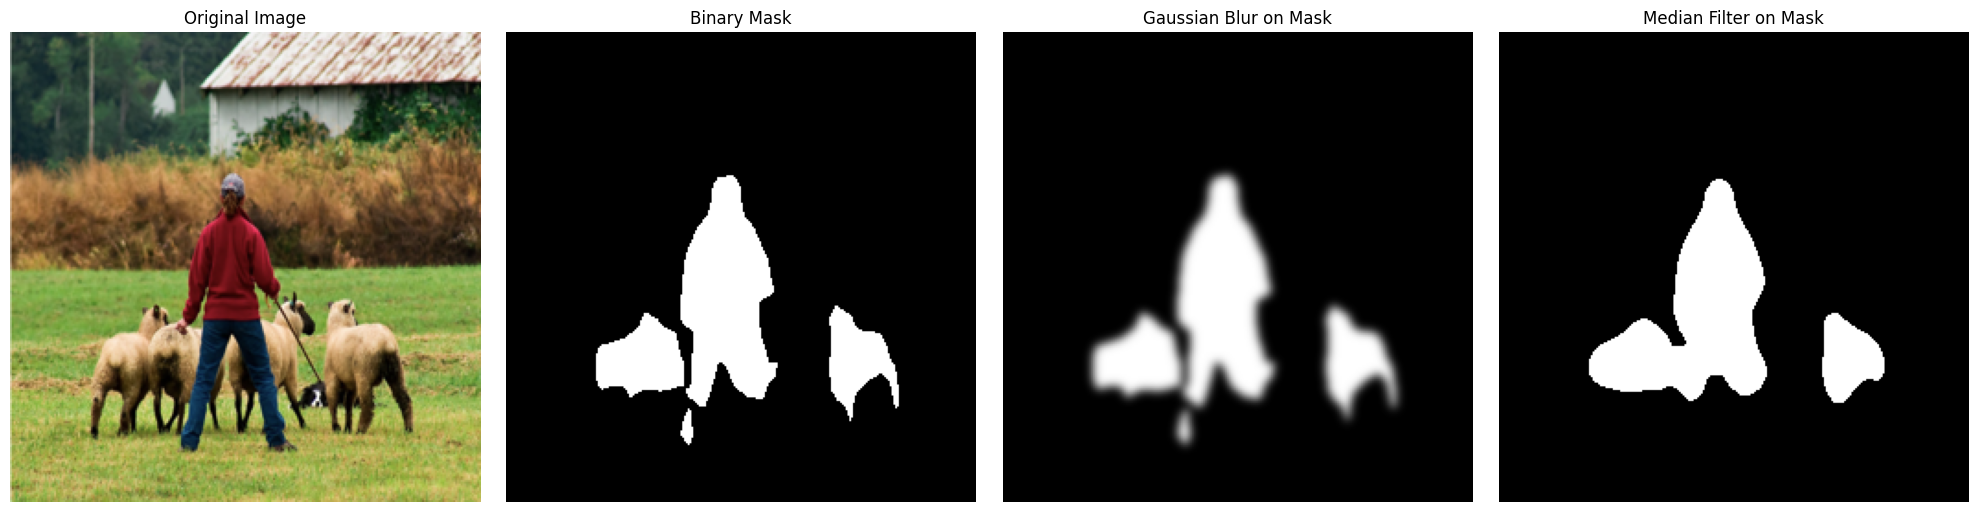

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import cv2  # Import OpenCV

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Pretrained DeepLabV3 (COCO)
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = models.segmentation.deeplabv3_resnet50(weights=weights).to(device).eval()

# ✅ Sample image URLs
sample_urls = [
    "https://pytorch.org/assets/images/deeplab1.png"
]

# ✅ Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# ✅ Main loop
for idx, url in enumerate(sample_urls):
    print(f"\nProcessing image {idx+1}/{len(sample_urls)}...")

    # Load image
    img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

    # Resize original image for consistent display
    original_img_resized = img.resize((256, 256))

    tensor = preprocess(img).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(tensor)['out']
    pred_mask = output.argmax(1).squeeze().cpu().numpy()

    # Create a binary black and white mask (subject vs. background)
    # Class 0 is typically the background in COCO dataset
    binary_mask = (pred_mask > 0).astype(np.uint8) * 255

    # Apply Gaussian Blur to the binary mask
    # Kernel size (15, 15) and sigmaX=0. Kernel size must be positive and odd.
    gaussian_blurred_mask = cv2.GaussianBlur(binary_mask, (15, 15), 0)

    # Apply Median Filtering to the binary mask
    # Kernel size 15. Must be an odd integer greater than 1.
    median_filtered_mask = cv2.medianBlur(binary_mask, 15)

    # Visualization of the original image and the masks
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(original_img_resized)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Binary Mask")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(gaussian_blurred_mask, cmap='gray')
    plt.title("Gaussian Blur on Mask")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(median_filtered_mask, cmap='gray')
    plt.title("Median Filter on Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

##pst prcessing pipine

Using device: cuda
Processing real image...


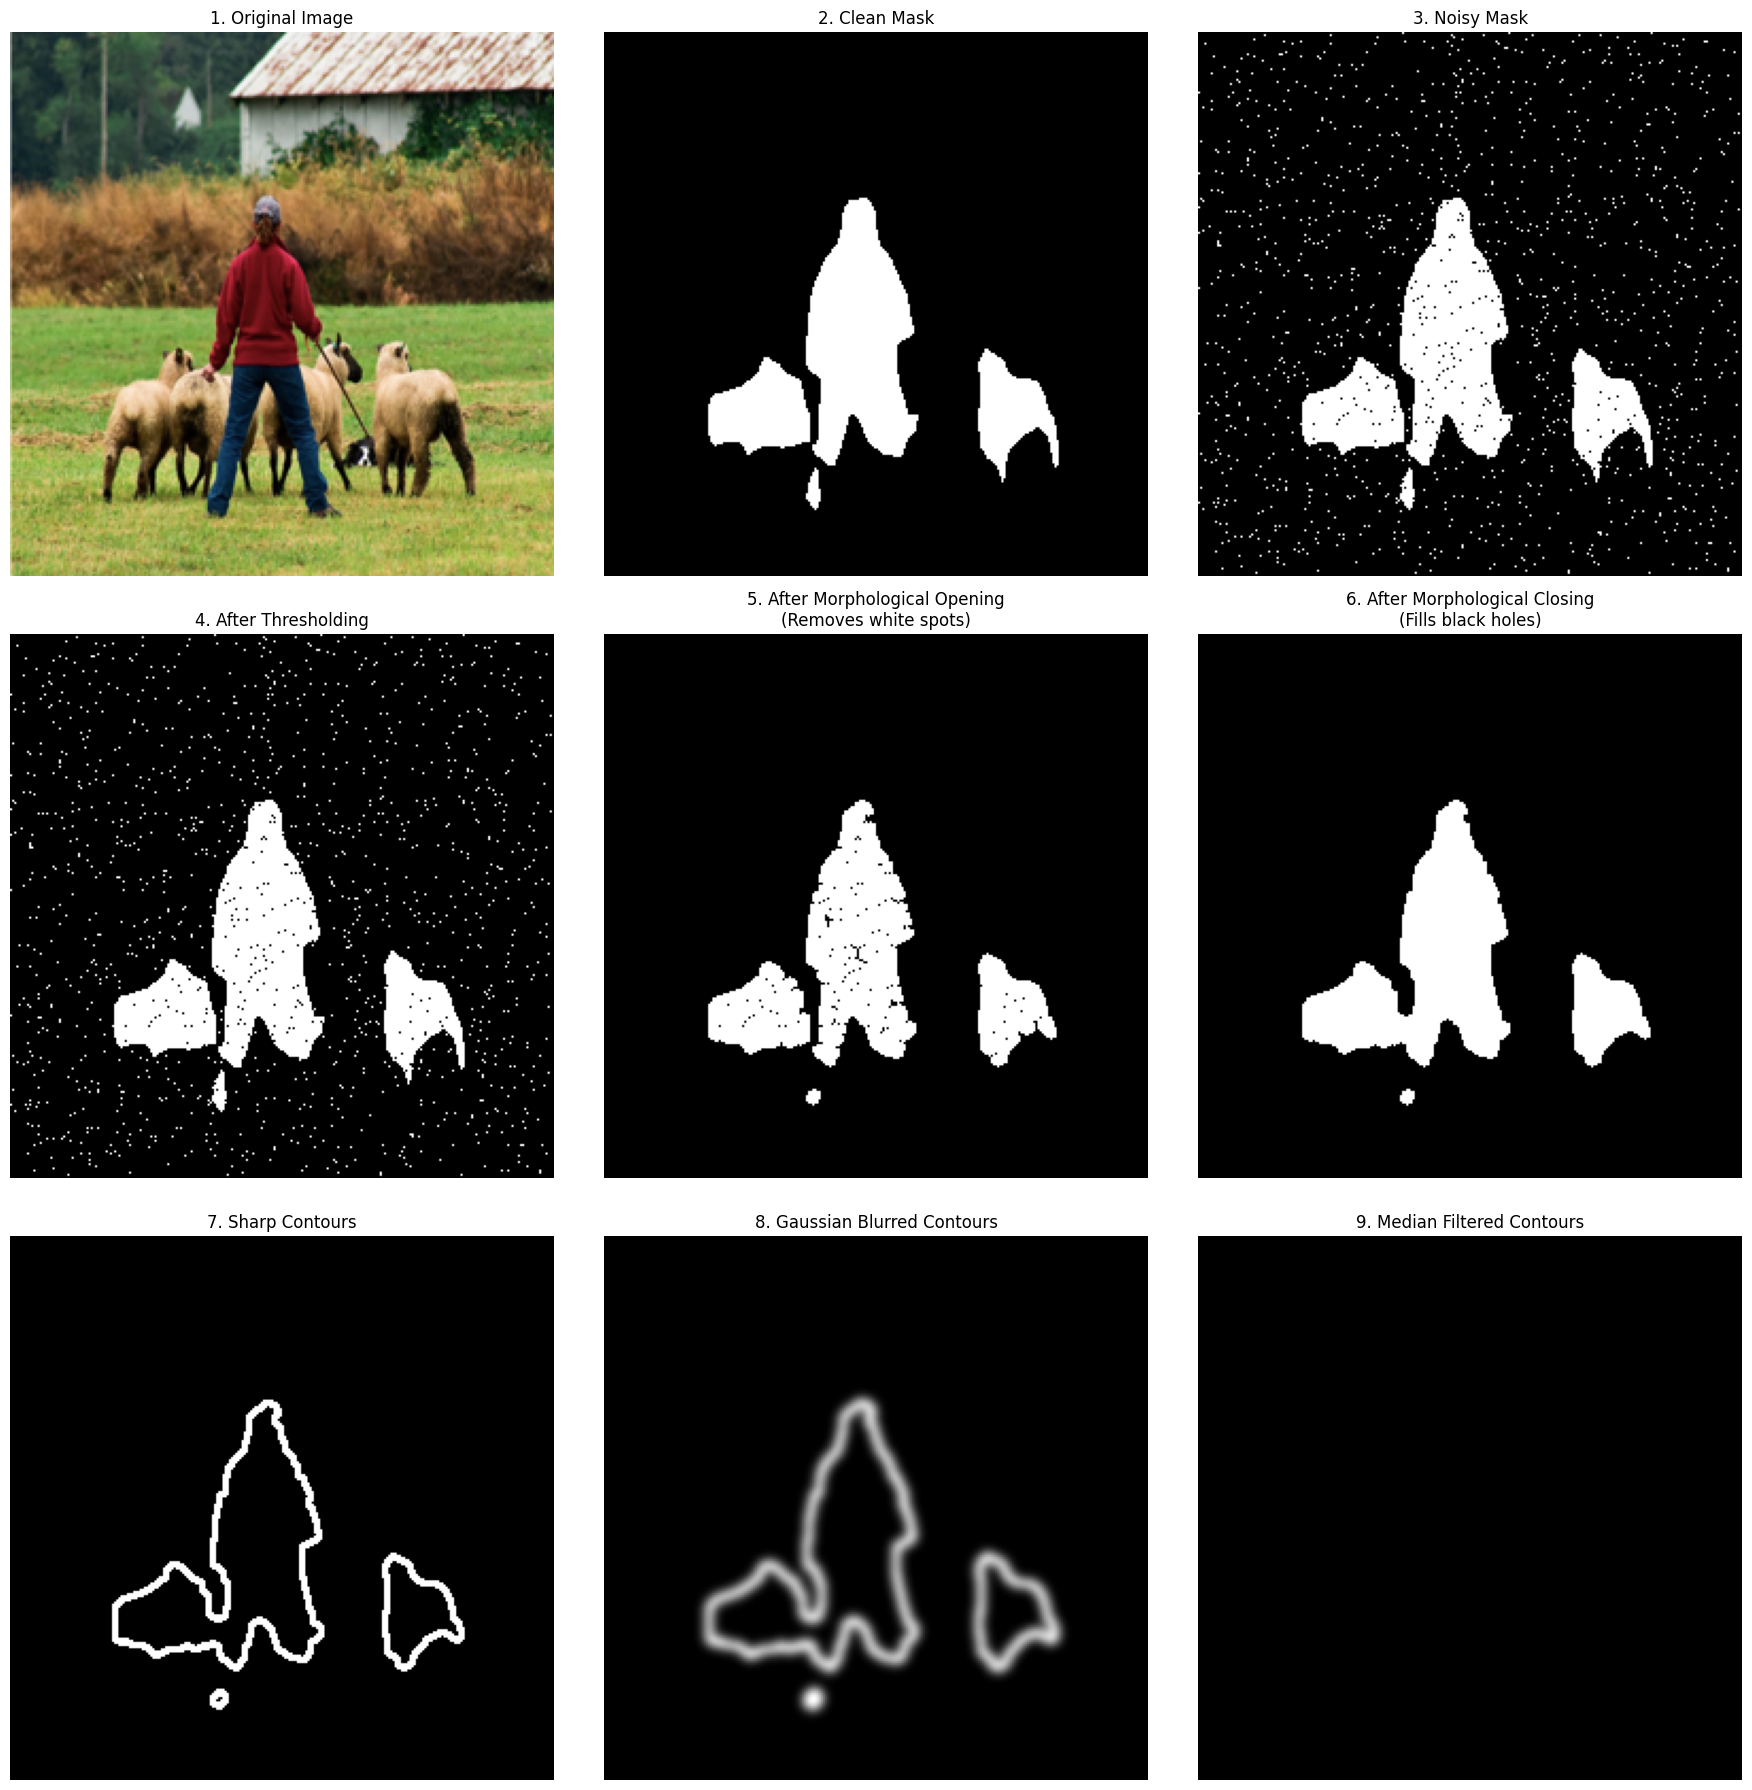

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import cv2  # Import OpenCV

# --- Setup for getting a real mask ---

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Pretrained DeepLabV3 (COCO)
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = models.segmentation.deeplabv3_resnet50(weights=weights).to(device).eval()

# ✅ Sample image URL
image_url = "https://pytorch.org/assets/images/deeplab1.png"

# ✅ Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# ✅ Helper function to add noise
def add_salt_and_pepper_noise(mask, salt_prob=0.02, pepper_prob=0.02):
    """Artificially adds salt (white) and pepper (black) noise to a binary mask."""
    noisy_mask = np.copy(mask)
    total_pixels = mask.size

    # Add salt noise (white spots)
    num_salt = int(total_pixels * salt_prob)
    salt_coords = [np.random.randint(0, i-1, num_salt) for i in mask.shape]
    noisy_mask[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise (black spots)
    num_pepper = int(total_pixels * pepper_prob)
    pepper_coords = [np.random.randint(0, i-1, num_pepper) for i in mask.shape]
    noisy_mask[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_mask

# --- 1. Load Real Image and Generate Clean Mask ---
print(f"Processing real image...")
img = Image.open(BytesIO(requests.get(image_url).content)).convert("RGB")
original_img_resized = img.resize((256, 256))
tensor = preprocess(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(tensor)['out']
real_pred_mask = output.argmax(1).squeeze().cpu().numpy()

clean_binary_mask = (real_pred_mask > 0).astype(np.uint8) * 255

# --- 2. Create the Noisy Mask ---
noisy_mask = add_salt_and_pepper_noise(clean_binary_mask, salt_prob=0.02, pepper_prob=0.02)

# --- 3. Post-Processing Pipeline (Cleaning) ---

# 3a. Thresholding
_, thresh_mask = cv2.threshold(noisy_mask, 127, 255, cv2.THRESH_BINARY)

# 3b. Morphological Operations
kernel_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

# Opening (Erosion -> Dilation)
opened_mask = cv2.morphologyEx(thresh_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# Closing (Dilation -> Erosion)
cleaned_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# --- 4. Contouring ---
contours, hierarchy = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image to draw the sharp, unblurred contours onto
contour_only_mask = np.zeros_like(cleaned_mask)
cv2.drawContours(contour_only_mask, contours, -1, 255, 2) # Draw contours in white, thickness 2

# --- 5. Apply Median and Gaussian Blur to the Contours ---

# 5a. Gaussian Blur
gaussian_blurred_contour = cv2.GaussianBlur(contour_only_mask, (15, 15), 0)

# 5b. Median Filtering
median_filtered_contour = cv2.medianBlur(contour_only_mask, 15)

# --- Visualization of All Steps ---
plt.figure(figsize=(18, 18))

# Row 1: Input
plt.subplot(3, 3, 1)
plt.imshow(original_img_resized)
plt.title("1. Original Image")
plt.axis("off")

plt.subplot(3, 3, 2)
plt.imshow(clean_binary_mask, cmap='gray')
plt.title("2. Clean Mask")
plt.axis("off")

plt.subplot(3, 3, 3)
plt.imshow(noisy_mask, cmap='gray')
plt.title("3. Noisy Mask")
plt.axis("off")

# Row 2: Cleaning Pipeline
plt.subplot(3, 3, 4)
plt.imshow(thresh_mask, cmap='gray')
plt.title("4. After Thresholding")
plt.axis("off")

plt.subplot(3, 3, 5)
plt.imshow(opened_mask, cmap='gray')
plt.title("5. After Morphological Opening\n(Removes white spots)")
plt.axis("off")

plt.subplot(3, 3, 6)
plt.imshow(cleaned_mask, cmap='gray')
plt.title("6. After Morphological Closing\n(Fills black holes)")
plt.axis("off")

# Row 3: Contour Filtering
plt.subplot(3, 3, 7)
plt.imshow(contour_only_mask, cmap='gray')
plt.title("7. Sharp Contours")
plt.axis("off")

plt.subplot(3, 3, 8)
plt.imshow(gaussian_blurred_contour, cmap='gray')
plt.title("8. Gaussian Blurred Contours")
plt.axis("off")

plt.subplot(3, 3, 9)
plt.imshow(median_filtered_contour, cmap='gray')
plt.title("9. Median Filtered Contours")
plt.axis("off")

plt.tight_layout()
plt.show()